In [12]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch import nn as nn
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision import datasets, transforms
from torch.nn.modules.conv import Conv2d
from torch.nn.modules.batchnorm import BatchNorm2d
from torch.nn.modules.pooling import MaxPool2d
from torch.nn.modules.activation import ReLU
from torch import optim

In [13]:
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.1307,), [0.3081])])

# Import the training and test datasets
mnist_trainset = datasets.MNIST(root='./data',
                                train=True, transform=transform, download=True)
mnist_testset  = datasets.MNIST(root='/data',
                                train=False, transform=transform, download=True)

In [14]:
# Combine the test and train dataset
mnist_dataset = mnist_trainset + mnist_testset

# prepare the dataloader
dataset_size = len(mnist_dataset)
indices      = list(range(dataset_size))
split        = int(np.floor(0.15 * dataset_size))

np.random.seed(2018)
np.random.shuffle(indices)

train_idx, test_idx = indices[split:], indices[:split]

sampler_train = SubsetRandomSampler(train_idx)
sampler_test  = SubsetRandomSampler(test_idx)

train_data = DataLoader(mnist_dataset, 
                              batch_size=128, sampler=sampler_train)
test_data  = DataLoader(mnist_dataset,
                             batch_size=128, sampler=sampler_test)

Text(0.5, 0.98, 'Images in the MNIST training set.')

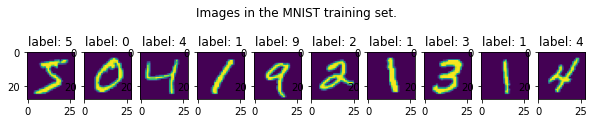

In [15]:
# Plot the images for different classes from the dataset
plt.figure(figsize=(10,2))
plt.title("Images in the MNIST training set.")
for i in range(10):
    plt.subplot(1, 10, i+1)
    plt.imshow(mnist_trainset.data[i].numpy())
    plt.title(f"label: {mnist_trainset.targets[i].numpy()}")

plt.suptitle("Images in the MNIST training set.")

In [16]:
class cnn_model(nn.Module):
    def __init__(self):
        super(cnn_model, self).__init__()
        self.conv1 = nn.Sequential(
                     nn.Conv2d(
                         in_channels=1,
                         out_channels=128,
                         kernel_size=3
                     ),
                     nn.BatchNorm2d(128),
                     nn.ReLU(),
                     nn.Conv2d(
                         in_channels=128,
                         out_channels=128,
                         kernel_size=3
                     ),
                     nn.BatchNorm2d(128),
                     nn.ReLU(),
                     nn.MaxPool2d(kernel_size=2),
                    )
        self.conv2 = nn.Sequential(
                     nn.Conv2d(
                         in_channels=128,
                         out_channels=128,
                         kernel_size=3
                     ),
                     nn.BatchNorm2d(128),
                     nn.ReLU(),
                     nn.Conv2d(
                         in_channels=128,
                         out_channels=128,
                         kernel_size=3
                     ),
                     nn.BatchNorm2d(128),
                     nn.ReLU(),
                     nn.Conv2d(
                         in_channels=128,
                         out_channels=64,
                         kernel_size=3
                     ),
                     nn.BatchNorm2d(64),
                     nn.ReLU(),
                     nn.MaxPool2d(kernel_size=2),
                    )
        
        self.classifier = nn.Sequential(
                     nn.Conv2d(
                         in_channels=64,
                         out_channels=10,
                         kernel_size=3
                     ),
                    )
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.classifier(x)

        return x.squeeze()

In [17]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
cnn = cnn_model().to(device)
metric_cnn = nn.CrossEntropyLoss().to(device)
optim_cnn  = optim.Adam(cnn.parameters(), lr=0.001)

In [23]:
def training(model, metric, optimizer, epochs, trainingData, testData):
    train_loss = list()
    train_acc  = list()
    eval_loss  = list()
    eval_acc   = list()

    for epoch in range(epochs):
        loss_train = 0      # loss every epoch
        acc_train  = 0      # accuracy every eppch
        model.train()

        for i, (img, label) in enumerate(trainingData):
            img   = img.to(device)
            label = label.to(device)
            optimizer.zero_grad()
            output = model(img)
            # compute the loss and accuracy for the models' output
            loss = metric(output, label)
            loss.backward()
            optimizer.step()
            loss_train += loss.item()
            __, pred = output.max(dim=1)
            num_correct = (pred == label).sum().item()
            acc = num_correct / img.shape[0]
            acc_train += acc

        loss_eval = 0
        acc_eval  = 0
        model.eval()
        with torch.no_grad():
            for i, (img, label) in enumerate(testData):
                img    = img.to(device)
                label  = label.to(device)
                output = model(img)
                # compute the loss and accuracy after evaluation
                loss = metric(output, label)
                loss_eval += loss.item()
                _, pred = output.max(dim=1)
                num_correct = (pred == label).sum().item()
                acc = num_correct / img.shape[0]
                acc_eval += acc

        loss_train /= len(trainingData)
        acc_train  /= len(trainingData)
        loss_eval  /= len(testData)
        acc_eval   /= len(testData)

        train_loss.append(loss_train)
        train_acc.append(acc_train)
        eval_loss.append(loss_eval)
        eval_acc.append(acc_eval)

        print("epoch: {}, \nTraining Loss: {:.6f}\n\
                            Training Acc : {:.6f}\n\
                            Eval Loss    : {:.6f}\n\
                            Eval Acc     : {:.6f}\n".format(epoch,
              loss_train, acc_train, loss_eval, acc_eval))
    
    return train_loss, train_acc, eval_loss, eval_acc


In [19]:
def plot_result(train, test, title, ylabel, xlabel='Epoch'):
    plt.plot(train)
    plt.plot(test)
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.title(title)
    plt.ylabel(ylabel)
    plt.xlabel(xlabel)

In [24]:
train_loss, train_acc, eval_loss, eval_acc = training(
    model=cnn,
    metric=metric_cnn,
    optimizer=optim_cnn,
    epochs=10,
    trainingData=train_data,
    testData=test_data
)

epoch: 0, 
Training Loss: 0.008707
                            Training Acc : 0.997295
                            Eval Loss    : 0.030237
                            Eval Acc     : 0.991529

epoch: 1, 
Training Loss: 0.007861
                            Training Acc : 0.997530
                            Eval Loss    : 0.026253
                            Eval Acc     : 0.992941

epoch: 2, 
Training Loss: 0.009611
                            Training Acc : 0.996640
                            Eval Loss    : 0.028422
                            Eval Acc     : 0.992470

epoch: 3, 
Training Loss: 0.007370
                            Training Acc : 0.997326
                            Eval Loss    : 0.035553
                            Eval Acc     : 0.991246

epoch: 4, 
Training Loss: 0.006491
                            Training Acc : 0.997732
                            Eval Loss    : 0.032371
                            Eval Acc     : 0.992188

epoch: 5, 
Training Loss: 0.005283
     

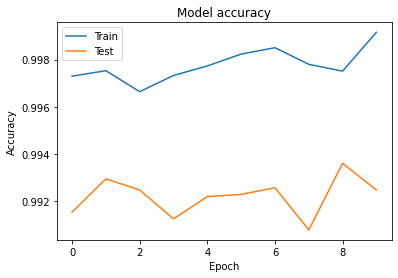

In [25]:
plot_result(train_acc, eval_acc, 'Model accuracy', 'Accuracy')

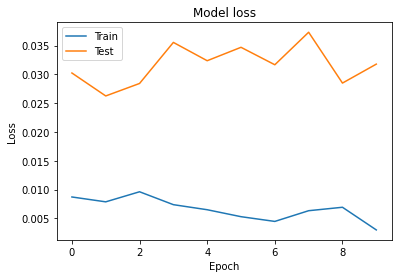

In [26]:
plot_result(train_loss, eval_loss, 'Model loss', 'Loss')